In [1]:
import latentvelo as ltv
import scanpy as sc
import scvelo as scv
import numpy as np
import torch as th
import anndata as ad

Global seed set to 0


In [2]:
adata = sc.read('../synthetic_datasets/synthetic_bifurcation.h5ad')
adata.layers['rna_velocity'] = np.array(adata.layers['rna_velocity'].todense())

milestones = adata.uns['traj_progressions']['from'].values + '->' + adata.uns['traj_progressions']['to'].values

for i in range(len(milestones)):
    
    state = milestones[i]
    
    if state == 'sA->sB' or state == 'sB->sBmid':
        milestones[i] = 'A'
    
    elif state == 'sBmid->sC':
        milestones[i] = 'B'
    
    elif state == 'sBmid->sD':
        milestones[i] = 'C'
    
    elif state == 'sC->sEndC':
        milestones[i] = 'D'
    elif state == 'sD->sEndD': 
        milestones[i] = 'E'

adata.obs['milestone'] = milestones

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


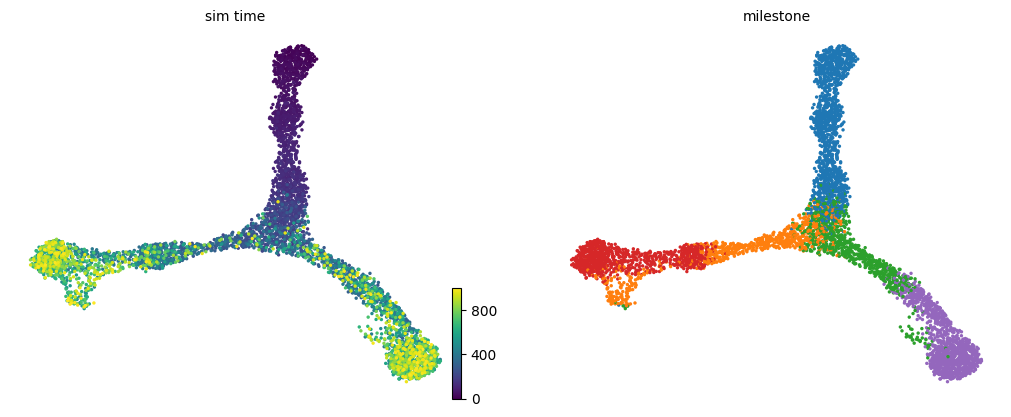

In [3]:
ltv.utils.standard_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 umap=True)
scv.pl.umap(adata, color=['sim_time', 'milestone'])

In [4]:
model = ltv.models.VAE(observed=65, latent_dim=20, zr_dim=1, h_dim=2)

In [5]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='bifurcation', grad_clip=100)

23 velocity genes used
epoch 0, full loss 138.080, val loss 53.568, recon MSE 2.516, traj MSE 0.631, reg loss -2.158
epoch 1, full loss 81.471, val loss 10.446, recon MSE 2.257, traj MSE 0.590, reg loss -2.440
epoch 2, full loss 91.810, val loss -29.696, recon MSE 1.877, traj MSE 0.345, reg loss -3.286
epoch 3, full loss 150.487, val loss -66.105, recon MSE 1.502, traj MSE 0.336, reg loss -3.184
epoch 4, full loss 252.422, val loss -93.340, recon MSE 1.289, traj MSE 0.322, reg loss -2.263
epoch 5, full loss 319.243, val loss -107.606, recon MSE 1.066, traj MSE 0.321, reg loss -2.360
epoch 6, full loss 383.629, val loss -114.249, recon MSE 0.934, traj MSE 0.319, reg loss -2.419
epoch 7, full loss 461.758, val loss -118.355, recon MSE 0.901, traj MSE 0.320, reg loss -2.254
epoch 8, full loss 493.550, val loss -119.088, recon MSE 0.845, traj MSE 0.314, reg loss -2.432
epoch 9, full loss 502.935, val loss -118.347, recon MSE 0.772, traj MSE 0.322, reg loss -2.365
epoch 10, full loss 461.58

computing velocity graph (using 12/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


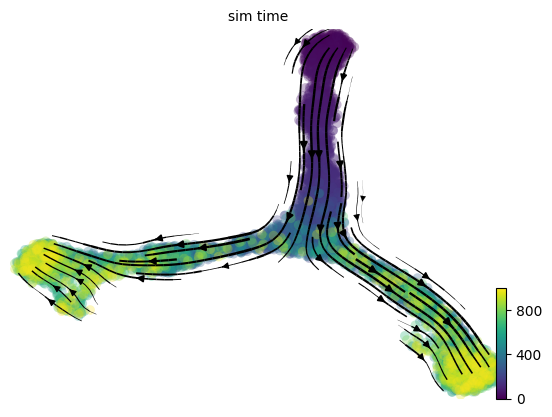

In [6]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', n_jobs=12)
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='sim_time')

# Perform benchmark

In [7]:
adata.layers['gene_velocity'] = adata.layers['velo'].copy()

cluster_edges = [('A', 'B'), ('B', 'D'), 
                ('A', 'C'), ('C', 'E')]

ltv.ev.format_benchmark_adata(adata, latent_adata, estimated_vkey='spliced_velocity')
results = ltv.ev.benchmark_synthetic(adata, estimated_vkey='gene_velocity', 
                                      sim_vkey='rna_velocity', 
                                      basis_list=['','latent','pca','pca_10', 'pca_3','umap'],
                                     cluster_edges = cluster_edges, cluster_key='milestone', avg_velocity=True)

adata.write('../benchmark/synthetic_trajectories/fits/bifurcation_adata.h5ad')
latent_adata.write('../benchmark/synthetic_trajectories/fits/bifurcation_latent_adata.h5ad')
results.to_csv('../benchmark/synthetic_trajectories/fits/bifurcation_results_df.csv')

computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:01) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.